<a href="https://colab.research.google.com/github/p25-c4/plate_project/blob/main/0312_GradientBoosting_plate_hy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report


# 팔레트 설정
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
# 맑은 고딕 적용
matplotlib.rc("font", family = "NanumGothic")
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_raw = pd.read_csv("/content/drive/MyDrive/BigData/real_final_scale.csv")
df_raw.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)


In [6]:
#df_raw['descaling_count'] = df_raw['descaling_count'].apply(lambda x: 'odd' if x % 2 != 0 else str(x))  # 홀수는 'odd', 짝수는 문자열로 범주화

In [7]:
df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale", 'steel_kind', 'day_yn', 'rolling_method'], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

In [8]:

# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char_1 = df_raw_x_1.select_dtypes(include = "object")
df_raw_x_char_2 = df_raw_x_2.select_dtypes(include = "object")
df_raw_x_char = pd.concat([df_raw_x_char_1, df_raw_x_char_2], axis=1)

# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy_1 = pd.get_dummies(df_raw_x_char_1)
df_x_dummy_2 = pd.get_dummies(df_raw_x_char_2, drop_first=True) # 범주가 2개인 자료는 따로 dummy화
df_x_dummy = pd.concat([df_x_dummy_1, df_x_dummy_2], axis=1)


# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country_일본,spec_country_프랑스,spec_country_한국,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,32,3700,15100,1,1,1144,116,1133,59,259,...,0,0,0,0,1,0,0,1,1,1
1,32,3700,15100,1,2,1144,122,1135,53,238,...,0,0,0,0,1,0,0,1,1,1
2,33,3600,19200,2,1,1129,116,1121,55,258,...,0,0,0,0,1,0,0,1,1,1


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country_일본,spec_country_프랑스,spec_country_한국,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,0.298839,1.765880,-1.561273,-1.227015,-0.982207,-0.623951,1.13104,-1.034421,-0.615879,0.534990,...,0,0,0,0,1,0,0,1,1,1
1,0.298839,1.765880,-1.561273,-1.227015,1.018115,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,...,0,0,0,0,1,0,0,1,1,1
2,0.354957,1.562785,-1.265674,-0.003875,-0.982207,-1.333010,1.13104,-1.728433,-0.809920,0.508684,...,0,0,0,0,1,0,0,1,1,1


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,purpose,steel_kind,day_yn,rolling_method
0,0.298839,1.765880,-1.561273,-1.227015,-0.982207,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,미국,선체구조용(조선용),T,주간,TMCP(온도제어)
1,0.298839,1.765880,-1.561273,-1.227015,1.018115,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,미국,선체구조용(조선용),T,주간,TMCP(온도제어)
2,0.354957,1.562785,-1.265674,-0.003875,-0.982207,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,영국,선체구조용(조선용),T,주간,TMCP(온도제어)


In [9]:
## train_test_split
# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.3, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
                                    , test_size = 0.3, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
                                    , test_size = 0.3, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())

'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country_일본,spec_country_프랑스,spec_country_한국,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
565,81,2900,9800,2,2,1139,132,1124,80,287,...,0,0,1,1,0,0,0,1,1,0
771,26,2600,31300,2,1,1165,73,1160,63,223,...,0,0,0,1,0,0,0,0,0,0
46,51,3100,12400,3,1,1133,57,1125,103,238,...,0,0,0,0,1,0,0,1,1,1
703,19,2700,54300,3,1,1178,69,1165,57,227,...,0,0,0,0,1,0,0,0,1,0
457,14,2900,54300,3,1,1166,72,1163,60,221,...,0,0,1,0,0,1,0,0,1,0


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,...,spec_country_일본,spec_country_프랑스,spec_country_한국,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
565,3.048596,0.141116,-1.943388,-0.003875,1.018115,-0.860304,1.737786,-1.554930,0.402834,1.271531,...,0,0,1,1,0,0,0,1,1,0
771,-0.037866,-0.468171,-0.393299,-0.003875,-0.982207,0.368730,-0.499588,0.527104,-0.421839,-0.411992,...,0,0,0,1,0,0,0,0,0,0
46,1.365071,0.547307,-1.755935,1.219266,-0.982207,-1.143928,-1.106333,-1.497096,1.518568,-0.017416,...,0,0,0,0,1,0,0,1,1,1
703,-0.430688,-0.265075,1.264936,1.219266,-0.982207,0.983248,-0.651274,0.816276,-0.712900,-0.306772,...,0,0,0,0,1,0,0,0,1,0
457,-0.711276,0.141116,1.264936,1.219266,-0.982207,0.416001,-0.537509,0.700607,-0.567369,-0.464602,...,0,0,1,0,0,1,0,0,1,0


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,purpose,steel_kind,day_yn,rolling_method
565,3.048596,0.141116,-1.943388,-0.003875,1.018115,-0.860304,1.737786,-1.554930,0.402834,1.271531,-0.990555,-1.594390,한국,OTHERS,T,주간,CR(제어압연)
771,-0.037866,-0.468171,-0.393299,-0.003875,-0.982207,0.368730,-0.499588,0.527104,-0.421839,-0.411992,1.328976,-0.342411,미국,OTHERS,C,야간,CR(제어압연)
46,1.365071,0.547307,-1.755935,1.219266,-0.982207,-1.143928,-1.106333,-1.497096,1.518568,-0.017416,-1.224065,-1.594390,미국,선체구조용(조선용),T,주간,TMCP(온도제어)
703,-0.430688,-0.265075,1.264936,1.219266,-0.982207,0.983248,-0.651274,0.816276,-0.712900,-0.306772,1.002062,0.909569,영국,선체구조용(조선용),C,주간,CR(제어압연)
457,-0.711276,0.141116,1.264936,1.219266,-0.982207,0.416001,-0.537509,0.700607,-0.567369,-0.464602,-0.274458,0.909569,한국,용접구조용,C,주간,CR(제어압연)


In [10]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncust = GradientBoostingClassifier()
gb_uncust.fit(df_train_x_rd, df_train_y)

# train 모델 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncust.score (df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncust.score (df_test_x_rd, df_test_y)))


Accuracy on training set: 1.000
Accuracy on test set: 0.989


In [11]:

# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경
para_lr = [lr * 0.02 for lr in range(1, 10)]
for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

# LearningRate별 정확도
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.02,0.968,0.954
1,0.04,0.995,0.975
2,0.06,1.000,0.979
3,0.08,1.000,0.989
4,0.10,1.000,0.989
5,0.12,1.000,0.993
6,0.14,1.000,0.989
7,0.16,1.000,0.993
8,0.18,1.000,0.996


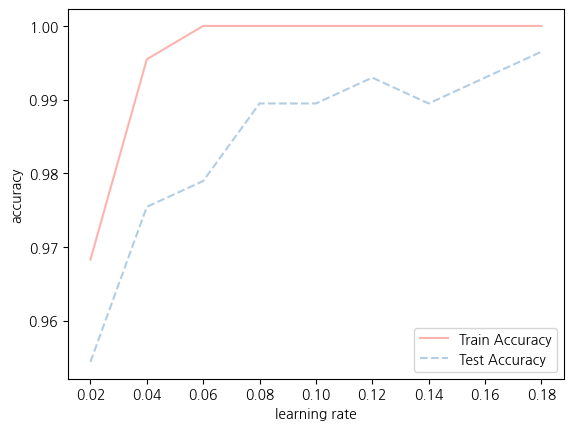

In [12]:

# LearningRate별 정확도 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

learning rate = 0.02  
0.02 이후로는 과적합 위험이 커지기 때문에 0.02로 선정.

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

# n_estimators별 정확도
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.728,0.709
1,20,0.968,0.954
2,30,0.968,0.954
3,40,0.968,0.954
4,50,0.968,0.954
5,60,0.968,0.954
6,70,0.968,0.954
7,80,0.968,0.954
8,90,0.968,0.954
9,100,0.968,0.954


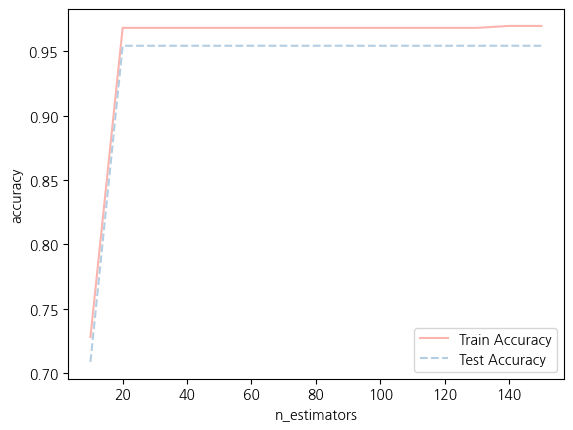

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

n_estimators = 20  

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경. 1~10
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth,
                            n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

# max_depth별 정확도
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.923,0.909
1,2,0.962,0.947
2,3,0.968,0.954
3,4,0.968,0.954
4,5,0.968,0.954
5,6,0.991,0.986
6,7,0.991,0.986
7,8,1.000,0.989
8,9,1.000,0.989
9,10,1.000,0.989


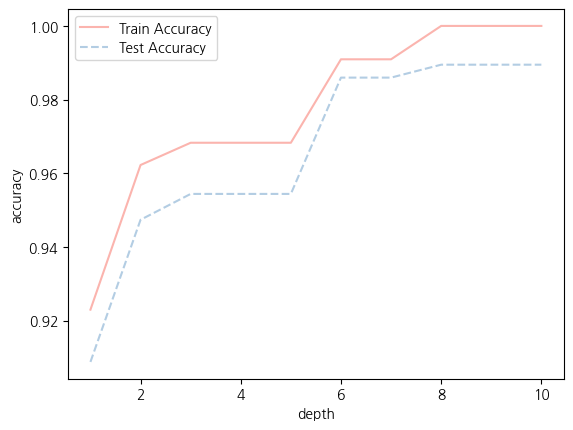

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

max depth = 6

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수. 20~100
para_split = [n_split * 10 for n_split in range(2, 5)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split,
                                    max_depth=6, n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.991,0.986
1,30,0.991,0.986
2,40,0.991,0.986


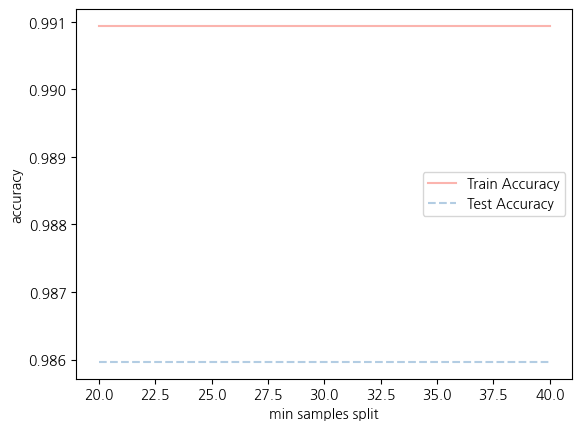

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples split")
plt.legend()

모델에 영향을 주지 않는 파라미터. 지정하지 않음

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 노드 최소 자료 수.
para_leaf = [n_leaf * 2 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf,
                                     max_depth=6, n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.991,0.986
1,4,0.991,0.986
2,6,0.985,0.979
3,8,0.985,0.979
4,10,0.985,0.979
5,12,0.985,0.979
6,14,0.985,0.979
7,16,0.962,0.947
8,18,0.962,0.947
9,20,0.962,0.947


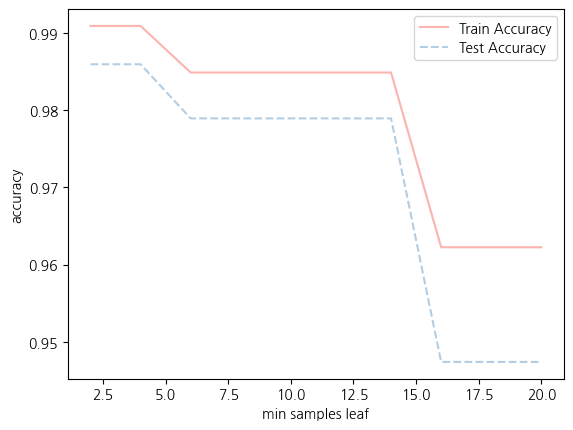

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()

min_samples_leaf =4

In [13]:
# 최종 모델
gb_final = GradientBoostingClassifier(max_depth=6, n_estimators=20, learning_rate=0.02, min_samples_leaf =4
                                      )
gb_final.fit(df_train_x_rd, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x_rd)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(gb_final.score(df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(gb_final.score(df_test_x_rd, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.991
Test Accuracy: 0.986

Test Confusion matrix: 
[[202   0]
 [  4  79]]
              precision    recall  f1-score   support

           0      0.981     1.000     0.990       202
           1      1.000     0.952     0.975        83

    accuracy                          0.986       285
   macro avg      0.990     0.976     0.983       285
weighted avg      0.986     0.986     0.986       285



1(불량) 기준 f1-score는 0.975이다. 더 나은 정확도를 위해 grid search로 최적 파라미터를 찾아보기로 한다.

In [14]:
# estimator = GradientBoostingClassifier()
# # 구하고자 하는 parameter와 범위
# param_grid = {"learning_rate": para_lr,
#               "max_depth": para_depth,
#               "min_samples_leaf": para_leaf,
#               "n_estimators" : [50,100,150]}
# # 정확도가 높은 최적 parameter 찾기
# grid_gb = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
# grid_gb.fit(df_train_x_rd, df_train_y)
# print("best estimator model: \n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_gb.best_params_))
# print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

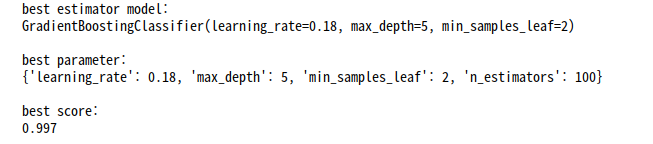

In [15]:
grid_gb = GradientBoostingClassifier(max_depth=5, n_estimators=100, learning_rate=0.18, min_samples_leaf =2)
grid_gb.fit(df_train_x_rd, df_train_y)
y_pred = grid_gb.predict(df_test_x_rd)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(grid_gb.score(df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(grid_gb.score(df_test_x_rd, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Train Accuracy: 1.000
Test Accuracy: 0.996

Test Confusion matrix: 
[[202   0]
 [  1  82]]


grid search로 돌린 모델을 최종 모델로 선정한다.

In [16]:
# 최종 모델
gb_final = GradientBoostingClassifier(max_depth=5, n_estimators=100, learning_rate=0.18, min_samples_leaf =2
                                      )
gb_final.fit(df_train_x_rd, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x_rd)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(gb_final.score(df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(gb_final.score(df_test_x_rd, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 1.000
Test Accuracy: 0.996

Test Confusion matrix: 
[[202   0]
 [  1  82]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       202
           1      1.000     0.988     0.994        83

    accuracy                          0.996       285
   macro avg      0.998     0.994     0.996       285
weighted avg      0.997     0.996     0.996       285



1(불량)을 기준으로 f1-score가 0.994이다. accuracy는 0.996 으로 매우 정확한 모델로 보인다.

In [17]:
# 변수명
v_feature_name = df_train_x_rd.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance10 = df_importance.head(10)
df_importance10 .round(3)

,Feature,Importance
10,rolling_temp,0.647
7,fur_soak_temp,0.169
11,descaling_count,0.135
0,pt_thick,0.044
1,pt_width,0.003
2,pt_length,0.001
8,fur_soak_time,0.001
20,purpose_선체구조용(조선용),0.000
9,fur_total_time,0.000
24,day_yn_주간,0.000


<ipython-input-19-c43b67e308ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance10 .sort_values("Importance", ascending=True, inplace = True)


Text(0, 0.5, '설명변수')

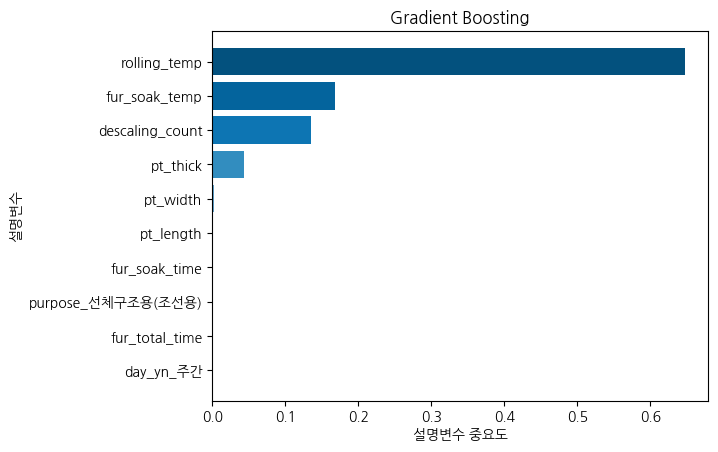

In [19]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위 10개 그림
df_importance10 .sort_values("Importance", ascending=True, inplace = True)

pubu = sns.color_palette("PuBu", len(df_importance10))
coordinates = range(len(df_importance10 ))
plt.barh(y = coordinates, width = df_importance10 ["Importance"], color=pubu)
plt.title("Gradient Boosting")
plt.yticks(coordinates, df_importance10 ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

rolling_temp, fur_soak_temp, descaling_count 순으로 중요하다.